In [1]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
import numpy as np
import pandas as pd
from chromax import Simulator
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import os
os.environ["KERAS_BACKEND"] = "jax"
import matplotlib
from jax import device_get
from scipy import stats

from typing import Dict, Any, List
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Lambda
import tensorflow as tf


2024-01-08 17:27:59.818896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def simplify_geneticmap(lst, qtl):
    # Select 'qtl' random indexes
    indexes_positive = random.sample(range(len(lst)), qtl)
    
    # Select 'qtl' random indexes not already selected
    remaining_indexes = set(range(len(lst))) - set(indexes_positive)
    indexes_negative = random.sample(remaining_indexes, qtl)

    # Modify the list
    for i in range(len(lst)):
        if i in indexes_positive:
            lst[i] = random.uniform(0.5, 1.0)  # Assign random float between 0.5 and 1.0
        elif i in indexes_negative:
            lst[i] = random.uniform(-0.5, -1.0)  # Assign random float between -0.5 and -1.0
        else:
            lst[i] = 0  # Assign 0

    return lst

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr


def reshape_pop(maizeHaplo):
    reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
    reshapeHaplo = reshapeHaplo.transpose((0,2,1))
    return reshapeHaplo

def return_genetic_map_df(markerEffects, nChr, geneticMap):
    chr = parse_markerEffects(markerEffects, nChr)
    chr = [int(x[0]) for x in chr]
    trait = markerEffects
    pos = geneticMap
    # Assuming chr, trait, pos are your arrays
    df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
    return df


In [3]:
%%R
x <- seq(0, 2*pi, length.out=50)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [4]:
%R -o x

In [5]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [6]:
# %R install.packages("AlphaSimR")

In [7]:
%%R
library("AlphaSimR")

Loading required package: R6


In [8]:
%%R
nInd = 10
nChr = 2
segSites = 5

founderGenomes = runMacs(nInd = nInd,
                         nChr = nChr,
                         segSites = segSites,
                         species = "MAIZE")


In [9]:
%%R
SP = SimParam$new(founderGenomes)
SP$addTraitA(segSites)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [10]:
%R -o maizeHaplo
%R -o maizeGeno
%R -o markerEffects
%R -o geneticMap
%R -o nInd
%R -o nChr
%R -o segSites

In [11]:
nMarkers = segSites * nChr

In [12]:
from statistics import mean

def split_and_average(lst, set_size):
    # lst is from get_baseline
    #average list
    lst = [x.mean() for x in lst]
    # Split the list into sublists
    split_lst = [lst[i:i + set_size] for i in range(0, len(lst), set_size)]

    # Calculate the average of the x-th element in each sublist
    averages = []
    for x in range(set_size):
        x_elements = [sublist[x] for sublist in split_lst if len(sublist) > x]
        averages.append(mean(x_elements))

    return averages

def sample_two_offspring_per_cross(dataset):
    """
    Samples two offspring per cross from the dataset.

    Parameters:
    dataset (np.ndarray): The input dataset with shape (n_cross, n_offspring, markers, diploid).

    Returns:
    np.ndarray: A new array with sampled offspring, shape (n_cross, 2, markers, diploid).
    """
    n_cross = dataset.shape[0]
    n_offspring_per_cross = 2
    # Create an array to store the indices of the offspring to sample
    indices = np.random.choice(dataset.shape[1], size=(n_cross, n_offspring_per_cross), replace=False)
    # Use advanced indexing to select two offspring per cross
    sampled_offspring = dataset[np.arange(n_cross)[:, None], indices, :, :]
    return sampled_offspring.reshape(-1, sampled_offspring.shape[2], sampled_offspring.shape[3])




def collapse_first_two_axes(dataset):
    """
    Collapses the first two axes of the dataset.

    Parameters:
    dataset (np.ndarray): The input dataset with shape (n_cross, n_offspring, markers, diploid).

    Returns:
    np.ndarray: A new array with the first two axes collapsed, shape (n_cross * n_offspring, markers, diploid).
    """
    # Calculate the new shape
    new_shape = (dataset.shape[0] * dataset.shape[1],) + dataset.shape[2:]
    # Reshape the dataset
    collapsed_dataset = dataset.reshape(new_shape)
    return collapsed_dataset





In [14]:
# # Example usage:
# number_individuals = 50  # Replace with your actual number of individuals
# number_markers = 100     # Replace with your actual number of markers
# ploidy = 2              # Replace with your actual ploidy level
# batch_size = 5
# batch_id=1 

# initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
# genetic_map_df = create_fake_geneticmap(number_markers)
# marker_strength = np.array(genetic_map_df['Yield'])

# dummy_score = np.random.rand(batch_size, number_individuals)

# actor_model = create_actor_model(number_individuals, number_markers, ploidy)
# critic_model = create_critic_model(number_individuals, number_markers, ploidy, actor_model)

In [15]:
# policy = actor_model([initial_population,dummy_score])
# value_estimate = critic_model([initial_population, dummy_score])

NameError: name 'actor_model' is not defined

In [16]:
# #split the population in half based on the policy metric
# top_policy_parents = select_parents(policy[batch_id,:].numpy(), total_parents=int(initial_population.shape[1] /2))[1].numpy()

# bottom_policy_parents = np.arange(initial_population.shape[1])
# bottom_policy_parents = np.setdiff1d(bottom_policy_parents, top_policy_parents)

# top_policy_parents = initial_population[batch_id][top_policy_parents]
# bottom_policy_parents = initial_population[batch_id][bottom_policy_parents]


In [ ]:
# true_scores = calculate_scores(initial_population[batch_id], marker_strength)

In [ ]:
# calculate_scores(panmixia(bottom_policy_parents, 500), marker_strength).mean()

In [ ]:
# new_pop = panmixia(top_policy_parents, 50)
# new_scores = calculate_scores(new_pop, marker_strength)
# print(new_scores.mean())
# new_parents = scores2parents(new_scores,25)

In [ ]:
# new_pop = panmixia(new_pop[new_parents], 50)
# new_scores = calculate_scores(new_pop, marker_strength)
# print(new_scores.mean())
# new_parents = scores2parents(new_scores,2)

In [17]:
# print(
#     f'''
#     Batch Size : {batch_size}
      
#     Population Size : {number_individuals}
#     Marker Count : {number_markers}

#     Population Input Shape : {initial_population.shape}
#     Scores Input Shape : {dummy_score.shape}

#     Policy Output Shape : {policy.shape}
#     Values Output Shape : {value_estimate.shape}
  
#     '''
#       )

NameError: name 'initial_population' is not defined

In [53]:
# FUNCTIONS FO SIMULATING THE ENVIRONMENT AND ACTIONS

def get_r(values):

    # Create an array of indices, same length as your list
    indices = np.array(range(len(values)))

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(indices, values)
    return slope

def add_batchdim(arr):
    return np.expand_dims(arr, axis=0)

def create_fake_geneticmap(number_markers):
    # 'chr' will always be '1A' for every marker
    chr_array = ['1A'] * number_markers
    
    # 'yield': Create a marker_strength array with 1 float between -0.5 and +0.5 randomly
    # yield_array = np.random.poisson(np.random.randint(1,10), size=number_markers)
    poisson_values = np.random.poisson(np.random.randint(1, 10), size=number_markers)

    # Scale the Poisson values to the range [0, 1]
    scaled_poisson_values = poisson_values / np.max(poisson_values)

    # Stretch and shift the values to the range [-1, 1]
    yield_array = (scaled_poisson_values * 2) - 1
    
    # 'cM': create an array for number_markers length evenly sampled between 0 and 100
    cM_array = np.linspace(0, 100, num=number_markers)
    
    # Create the DataFrame with the auto-generated data
    df = pd.DataFrame({'CHR.PHYS': chr_array, 'Yield': yield_array, 'cM': cM_array*.01})
    
    return df

import numpy as np
from random import choice, shuffle

def create_fake_population(total_pops, number_individuals, number_markers, ploidy):
    # List of generation methods
    generation_methods = [
        lambda: np.random.randint(2, size=(number_individuals, number_markers, ploidy)),
        lambda: np.random.rand(number_individuals, number_markers, ploidy),
        lambda: np.random.standard_normal((number_individuals, number_markers, ploidy)),
        lambda: np.random.choice([0, 1], size=(number_individuals, number_markers, ploidy))
    ]
    
    populations = []
    for _ in range(total_pops):
        # Randomly select a generation method and generate the population
        gen_method = choice(generation_methods)
        population = gen_method()
        populations.append(population)
        
    # Combine all populations into a single numpy array
    combined_population = np.array(populations)
    return combined_population




def calculate_scores(population, marker_strength):
    """
    Calculates the additive score by matrix multipling the population (n,m) with the marker strengths (m,)
    """
    # Perform a dot product between the dosages and marker strength arrays
    dosages = np.sum(population,axis=2)
    scores = np.dot(dosages, marker_strength)
    return scores

def panmixia(selected_parents, total_offspring = 2):
    """ Handles the random crossing for us ; heuristic!

    selected_parents ( n , m , d )
    
    """
    n, m, d = selected_parents.shape
    offspring_target = total_offspring
    offspring_list = []

    while len(offspring_list) < offspring_target:
        # Randomly pick two parents without replacement
        parents_indices = np.random.choice(n, size=2, replace=False)
        parent1, parent2 = selected_parents[parents_indices]

        # Simulate random recombination for each marker
        offspring = np.zeros((m, d), dtype=parent1.dtype)
        for i in range(m):
            # Randomly choose one allele from each parent for each marker
            for j in range(d):
                parent_allele = np.random.choice([parent1[i, j], parent2[i, j]])
                offspring[i, j] = parent_allele

        # Add the new offspring to the offspring list
        offspring_list.append(offspring)

    # Convert offspring list to a numpy array with shape (offspring_target, m, d)
    offspring_array = np.array(offspring_list)
    return offspring_array


def scores2parents(scores,K):
    """
    hint: use output from calculate_scores
    """
    # Specify the number of top values you want (K)
    K = 5

    # Get the indices that would sort the array
    sorted_indices = np.argsort(scores)

    # Take the last K indices of the sorted indices array
    top_k_indices = sorted_indices[-K:]

    # Since argsort returns indices in ascending order, reverse to get the top values
    top_k_indices = top_k_indices[::-1]

    print("Indices of top K values:", top_k_indices)
    print("Top K values:", scores[top_k_indices])

    return top_k_indices


def select_parents(policy, total_parents):
    """
        input: Policy from actor ( metric value for each individual )
        returns : index of parents to be included in random_crosses for next step of breeding program
    """
    values, indices = tf.math.top_k(policy, total_parents)
    return values,indices

def create_actor_model(num_individuals, num_markers, ploidy):
    # Define the input layers
    population_input = Input(shape=(num_individuals, num_markers, ploidy), name='population_input')
    scores_input = Input(shape=(num_individuals,), name='scores_input')

    # Flatten the population input to process it with Dense layers
    flat_population = Flatten()(population_input)

    # Combine the flattened population and scores inputs
    combined_input = Concatenate()([flat_population, scores_input])

    # Define the hidden layers
    hidden1 = Dense(128, activation='relu')(combined_input)
    hidden2 = Dense(64, activation='relu')(hidden1)

    # Output layer with one scalar value per individual
    policy_output = Dense(num_individuals, activation='sigmoid', name='policy_output')(hidden2)

    # Create the actor model
    actor_model = Model(inputs=[population_input, scores_input], outputs=policy_output)

    return actor_model

def create_critic_model(num_individuals, num_markers, ploidy, actor_model):
    # Define the input layers
    population_input = Input(shape=(num_individuals, num_markers, ploidy), name='population_input')
    scores_input = Input(shape=(num_individuals,), name='scores_input')

    # Call the actor model to get the policy output for the given state
    policy_output = actor_model([population_input, scores_input])

    # Use Lambda layer to apply tf.stop_gradient to prevent backpropagation
    policy_output_no_gradient = Lambda(lambda x: tf.stop_gradient(x))(policy_output)

    # Flatten the population input to process it with Dense layers
    flat_population = Flatten()(population_input)

    # Combine the flattened population, scores, and policy outputs without gradients
    combined_input = Concatenate()([flat_population, scores_input, Flatten()(policy_output_no_gradient)])

    # Define the hidden layers
    hidden1 = Dense(128, activation='relu')(combined_input)
    hidden2 = Dense(64, activation='relu')(hidden1)

    # Output layer with a single value estimate for the state
    value_output = Dense(1, activation='linear', name='value_output')(hidden2)

    # Create the critic model
    critic_model = Model(inputs=[population_input, scores_input], outputs=value_output)

    return critic_model




class BreederAgent:
    """
    A PPO agent that learns to select parents for breeding programs using Actor-Critic method.
    """
    
    def __init__(self, config: Dict[str, Any]):
        """
        Initializes the breeding program with a configuration dictionary.
        
        Parameters:
        config (dict): Configuration dictionary containing all necessary parameters.
        """

        # Initialize the basic attributes from the config
        self.compute_baselines = config.get('compute_baselines', False)
        self.population_size = config['population_size']
        self.marker_count = config['marker_count']
        self.initial_population = config['initial_population']
        self.genetic_map = config['genetic_map']
        self.marker_strength = np.array(self.genetic_map['Yield'])
        self.initial_score = np.array([calculate_scores(x,self.marker_strength) for x in self.initial_population])

        self.ploidy = config['ploidy']


        # Initialize the Actor and Critic models
        self.actor = create_actor_model(num_individuals=self.population_size, num_markers=self.marker_count, ploidy=self.ploidy)
        self.critic = create_critic_model(num_individuals=self.population_size, num_markers=self.marker_count, ploidy=self.ploidy, actor_model=self.actor)


        #truncation and random baselines
        # self.truncation_baseline = [calculate_scores(x, self.marker_strength) for x in self.initial_population]
        # truncation_baseline = self.breeding_simulator.select(self.initial_population, k = int(self.initial_population.shape[0]/2))
        # self.truncation_baseline = self.breeding_simulator.GEBV(collapse_first_two_axes(self.breeding_simulator.random_crosses(truncation_baseline, n_crosses = truncation_baseline.shape[0], n_offspring=50))).mean()[0]

        # self.random_baseline = self.breeding_simulator.GEBV(collapse_first_two_axes(self.breeding_simulator.random_crosses(self.initial_population, n_crosses = self.initial_population.shape[0], n_offspring=50))).mean()[0]


    def reset_environment(self):
        self.current_population = self.initial_population
        self.current_scores = self.initial_score

# Example usage:
number_individuals = 50  # Replace with your actual number of individuals
number_markers = 100     # Replace with your actual number of markers
ploidy = 2              # Replace with your actual ploidy level
batch_size = 3
initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
genetic_map_df = create_fake_geneticmap(number_markers)
marker_strength = np.array(genetic_map_df['Yield'])
fraction_selection = 10

config = {
    'compute_baselines': False,
    'initial_population': initial_population,
    'genetic_map': genetic_map_df,
    'population_size': number_individuals,
    'marker_count': number_markers,
    'heritability': .99,
    'episodes': 10,
    'cycles': 2,
    'learning_rate': .001,
    'replicates': 1,
    'ploidy':2,
}



[0.9965328598148485, -0.14065035839484882, 0.3813741116131425]


[[<matplotlib.lines.Line2D at 0x7f4d487b2520>],

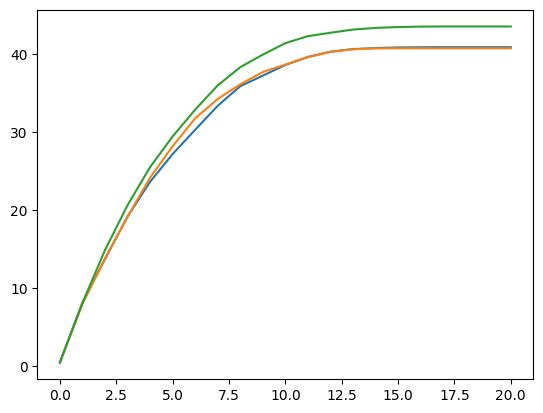

In [249]:
#Truncation Selection program

agent = BreederAgent(config)

# policy = actor_model([initial_population,dummy_score])
# value_estimate = critic_model([initial_population, dummy_score])


print([x.mean() for x in agent.initial_score])
# example using the raw scores (no actor/critic)
rep_scores = []
for e in range(3):
    scores = []
    agent.current_population = agent.initial_population
    agent.current_score = agent.initial_score
    for c in range(20):#action
        if c == 0:
            scores.append(agent.current_score.mean())

        selected_parents = [select_parents(x, total_parents = int(agent.population_size/fraction_selection))[1].numpy() for x in agent.current_score]
        subset_parents = [s[p] for s,p in zip(agent.current_population,selected_parents)]


        #view new environment
        new_pops = [panmixia(x, total_offspring=100) for x in subset_parents]
        sample_index = np.random.choice(new_pops[0].shape[0], size=agent.population_size, replace=False)
        new_pops = [x[sample_index] for x in new_pops]
        scored_pops = [calculate_scores(x,agent.marker_strength) for x in new_pops]
        new_pops = np.array(new_pops)
        scored_pops = np.array(scored_pops)

        # Add assertions here
        assert np.array(agent.current_population).shape == np.array(new_pops).shape, "Dimensions of current_population and new_pops do not match"
        assert np.array(agent.current_score).shape == np.array(scored_pops).shape, "Dimensions of current_score and scored_pops do not match"

        agent.current_population = new_pops
        agent.current_score = scored_pops
        scores.append(scored_pops.mean())
    rep_scores.append(scores)
    
[plt.plot(x,label=f'batch {c}') for c,x in enumerate(rep_scores)]

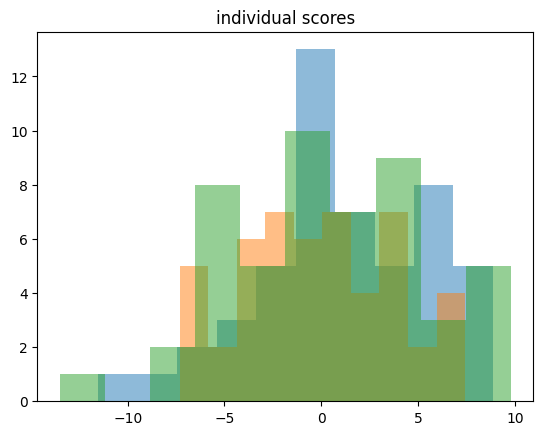

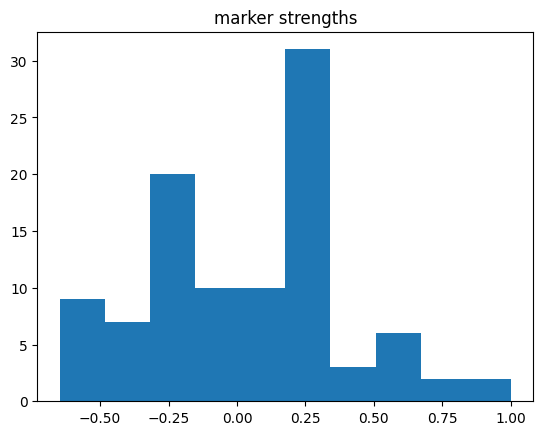

In [250]:
[plt.hist(x,alpha=.5) for x in agent.initial_score]
plt.title('individual scores')
plt.show()
plt.hist(agent.marker_strength)
plt.title('marker strengths')
plt.show()

In [251]:
def ppo_step(agent, parent_index, cycle, total_cycles):
    """
    Takes an action in the environment and returns the next state, reward, and a done flag.

    Inputs:
    - agent: An instance of the BreederAgent class.
    - parent_index (batch_size, selected_parent_count): The indices of selected parents for breeding. FROM POLICY
    - cycle: The current cycle number within the episode.
    - total_cycles: The total number of cycles in an episode.

    Outputs:
    - step_data: A list of dictionaries, each containing the new state, reward, and done flag for a batch.
    """
    step_data = []
    #parents_index is calculated by the actor
    for c, x in enumerate(parent_index):  # for each batch
        parents_subpop = agent.current_population[c][x]
        mass_pop = panmixia(parents_subpop, total_offspring=agent.population_size * 5)
        mass_score = calculate_scores(mass_pop, agent.marker_strength)
        prev_score = agent.current_score[c].mean()
        reward = mass_score.mean() - prev_score

        # Sample a subset of the new population to form the next state
        new_pop_indices = np.random.choice(mass_pop.shape[0], size=agent.population_size, replace=False)
        new_pop = mass_pop[new_pop_indices]
        new_score = calculate_scores(new_pop, agent.marker_strength)

        done = (cycle == total_cycles - 1)
        batch_data = {
            'new_population': new_pop,
            'new_score':new_score,  # Store the actual next state
            'reward': reward,
            'previous_score': prev_score,
            'current_score': new_score.mean(),
            'done': done
        }
        step_data.append(batch_data)

    return step_data


In [296]:
#PPO Training Loop

#Initialize the environment, actor, and critic models, and set up any necessary tracking variables for rewards, scores, and baselines.

number_individuals = 50  # Replace with your actual number of individuals
number_markers = 100     # Replace with your actual number of markers
ploidy = 2              # Replace with your actual ploidy level
batch_size = 3

initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
genetic_map_df = create_fake_geneticmap(number_markers)
marker_strength = np.array(genetic_map_df['Yield'])
selection_fraction = 3 #TOADD EVERYWEHRE( top 1/3)
config = {
    'compute_baselines': False,
    'initial_population': initial_population,
    'genetic_map': genetic_map_df,
    'population_size': number_individuals,
    'marker_count': number_markers,
    'heritability': .99,
    'episodes': 10,
    'cycles': 6,
    'learning_rate': .001,
    'replicates': 1,
    'ploidy':2,
}

agent = BreederAgent(config)

#Policy Based Step
agent.current_population = agent.initial_population
agent.current_score = agent.initial_score

# policy = agent.actor([agent.current_population, agent.current_score])
# value = agent.critic([agent.current_population, agent.current_score], agent.actor)

In [317]:
#Collect Single Episode of 5 Cycles With Current Policy
agent.episodes = 1
agent.cycles=10


breeding_steps = []
for c in range(agent.cycles):
    policy = agent.actor([agent.current_population, agent.current_score])
    value = agent.critic([agent.current_population, agent.current_score], agent.actor)
    parent_data = [select_parents(x, selection_fraction) for x in policy]
    parent_score = [x[0].numpy() for x in parent_data] # contains policys metric of selected parents
    parent_index = [x[1].numpy() for x in parent_data] # contains index of selected parents
    breeding_step = ppo_step(agent,parent_index,c,agent.cycles)
    new_pops = np.array([x['new_population'] for x in breeding_step])
    new_scores = np.array([x['new_score'] for x in breeding_step])
    agent.current_population = new_pops
    agent.current_score = new_scores
    breeding_steps.append(breeding_step)

In [350]:

"""

In summary, the advantage you are calculating is effectively measuring the relative benefit 
of the breeding decisions made by the agent compared to the expected outcome of the current
policy. It is a crucial component in training the agent, as it guides the optimization 
process towards decisions that yield better-than-average improvements in the plant population.

The advantage of a breeding decision (action) is the difference between the reward from that 
decision and the critic's estimated value of the population before breeding. If the advantage
is positive, it means that the breeding decision led to a better-than-expected improvement
in the population's mean score.

"""

# Calculate Advantages

advantages = []
agent.gamma = .95
# Assuming agent.gamma is the discount factor
gamma = agent.gamma

for cycle, step in enumerate(reversed(breeding_steps)):
    # The reversed list index starts from the last to the first
    reversed_cycle = (len(breeding_steps) - 1) - cycle

    # Get the reward and new values
    reward = np.array([x['reward'] for x in breeding_steps[reversed_cycle]])
    new_score = np.array([x['new_score'] for x in breeding_steps[reversed_cycle]])
    new_pop = np.array([x['new_population'] for x in breeding_steps[reversed_cycle]])
    new_value = agent.critic([new_pop, new_score])

    if reversed_cycle > 0:
        # If not the first cycle, get the previous values
        old_score = np.array([x['new_score'] for x in breeding_steps[reversed_cycle - 1]])
        old_pop = np.array([x['new_population'] for x in breeding_steps[reversed_cycle - 1]])
        old_value = agent.critic([old_pop, old_score])
    else:
        # For the first cycle, there is no previous value, set to 0 or handle accordingly
        old_value = np.zeros_like(new_value)

    # Calculate advantage
    delta = reward + gamma * new_value - old_value
    advantages.append(delta)


# meant to evaluate how good the decision to select certain individuals for breeding 
# (action) was, compared to an average or baseline selection strategy (state value)

# Convert list of advantages to a numpy array
advantages = np.array(advantages)

# Remember to reverse the advantages array so it corresponds to the original order
advantages = np.flip(advantages, axis=0)


In [347]:
advantages.shape

(10, 3, 3)

In [ ]:
for cycle in breeding_steps:
    cycle_pops = np.array([x['new_population'] for x in cycle])
    cycle_scores = np.array([x['new_score'] for x in cycle]) 

In [301]:
len(breeding_steps)

10

In [303]:
len(breeding_steps[0])

3

In [311]:
cycle_scores.shape

(3, 50)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.47384393],
       [0.4247918 ],
       [0.52976894]], dtype=float32)>

In [295]:
np.array(breeding_steps).shape

(6, 3)

In [291]:

all_critic_values = []
for batch in breeding_steps:
    pops = [x['new_population'] for x in cycle]
    print(len(pops))

3
3
3
3
3
3


In [293]:
pops[0].shape

(50, 100, 2)

In [264]:

all_critic_values = []
for cycle in breeding_steps:
    cycle_critic_values = []
    for step in cycle: # episode 0 cycle 0 # for each batch
        population = step['new_population']
        score = step['new_score']


        # scores = [x['new_score'] for x in cycle]
        # pops = [x['new_population'] for x in cycle]
        rewards = [x['reward'] for x in cycle]

        pops = np.array(pops)
        scores = np.array(score)

        critic_values = agent.critic([pops, scores])
        critic_values = [x[0] for x in critic_values.numpy()]
        cycle_critic_values.append(critic_values)
    all_critic_values.append(cycle_critic_values)

(50,) (50,)


InvalidArgumentError: Exception encountered when calling layer 'concatenate_56' (type Concatenate).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Ranks of all input tensors should match: shape[0] = [3,10000] vs. shape[1] = [50] [Op:ConcatV2] name: concat

Call arguments received by layer 'concatenate_56' (type Concatenate):
  • inputs=['tf.Tensor(shape=(3, 10000), dtype=float32)', 'tf.Tensor(shape=(50,), dtype=float32)']

In [268]:
agent.critic([pops, scores])

InvalidArgumentError: Exception encountered when calling layer 'concatenate_56' (type Concatenate).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Ranks of all input tensors should match: shape[0] = [3,10000] vs. shape[1] = [50] [Op:ConcatV2] name: concat

Call arguments received by layer 'concatenate_56' (type Concatenate):
  • inputs=['tf.Tensor(shape=(3, 10000), dtype=float32)', 'tf.Tensor(shape=(50,), dtype=float32)']

In [270]:
pops.shape

(3, 50, 100, 2)

In [271]:
score.shape

(50,)

In [262]:
score.shape

(50,)

In [256]:
scores.shape

(21,)

In [ ]:
        critic_values = agent.critic([pops, scores])
